In [ ]:
# TODO: change from mounting drive to local files
# TODO: add tests
# TODO: before submitting, apply PEP8 formatting

from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/gsoc-evaluation-task/

%ls

### Configurations and Libraries



In [1]:
# TODO: change from mounting drive to local files
# TODO: add tests

In [64]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from generator import RegionETGenerator
import time
import pandas as pd
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'seaborn'

In [3]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

### Load & Describe Data

In [30]:
data_path = Path('data')
model_path = Path('model')

In [31]:
images = np.load(data_path / 'images.npy')
labels = np.load(data_path / 'labels.npy')

In [32]:
print(f"Data type of images: {images.dtype}")
print(f"Data type of labels: {labels.dtype}")

Data type of images: float64
Data type of labels: int64


In [673]:
# TODO: can we keep generic? what if it's a string?
def labels_description(data: NDArray[np.int64]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float64]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [645]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [646]:
labels_description(labels)

                0
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None


In [693]:
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=101,)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.2, random_state=101,)

### Data Visualization

In [697]:
# TODO: check the type of pixels
def print_random_image(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')
  
def print_images_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  all_pixels = images.flatten()

  # Plot the histogram of pixel intensities
  plt.figure(figsize=(10, 6))
  sns.histplot(all_pixels, kde=True, color='blue', bins=50)

  # Customize the plot
  plt.title('Histogram of Pixel Intensities for All Images')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')

  # Show the plot
  plt.show()

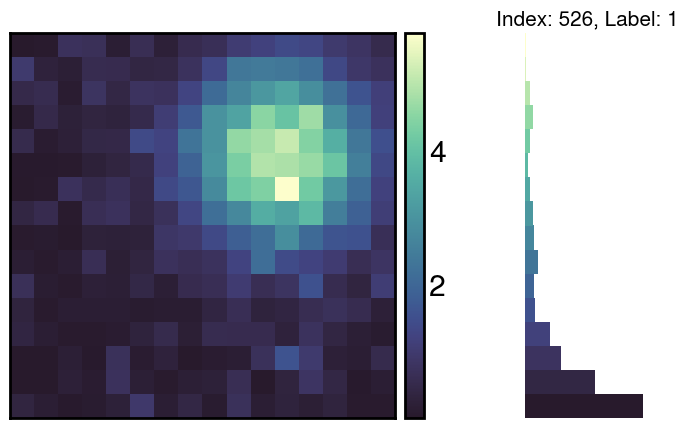

In [695]:
# TODO: histogram of pixel intensities using seaborn (or alternatives)
print_image_distribution(images_train, labels)

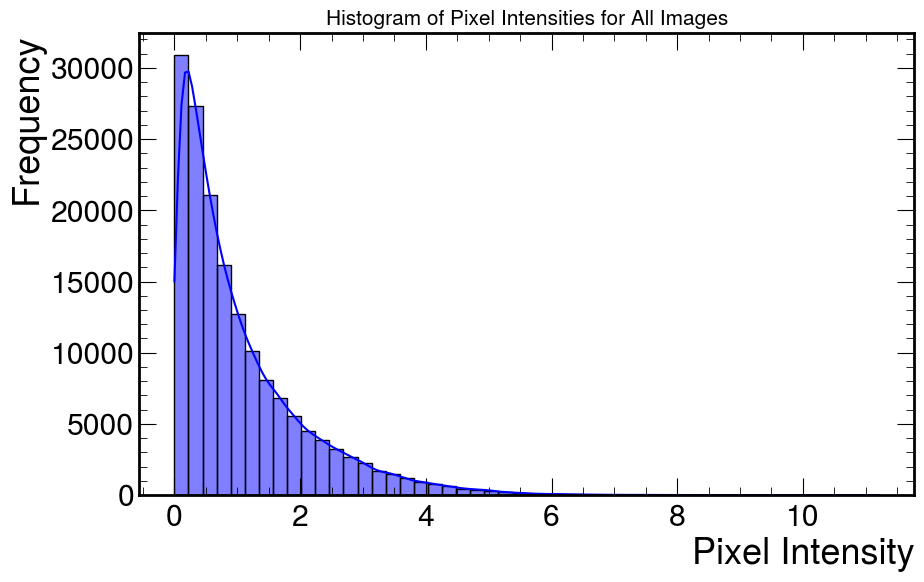

In [698]:
print_images_distribution(images_train, labels)

([], [])

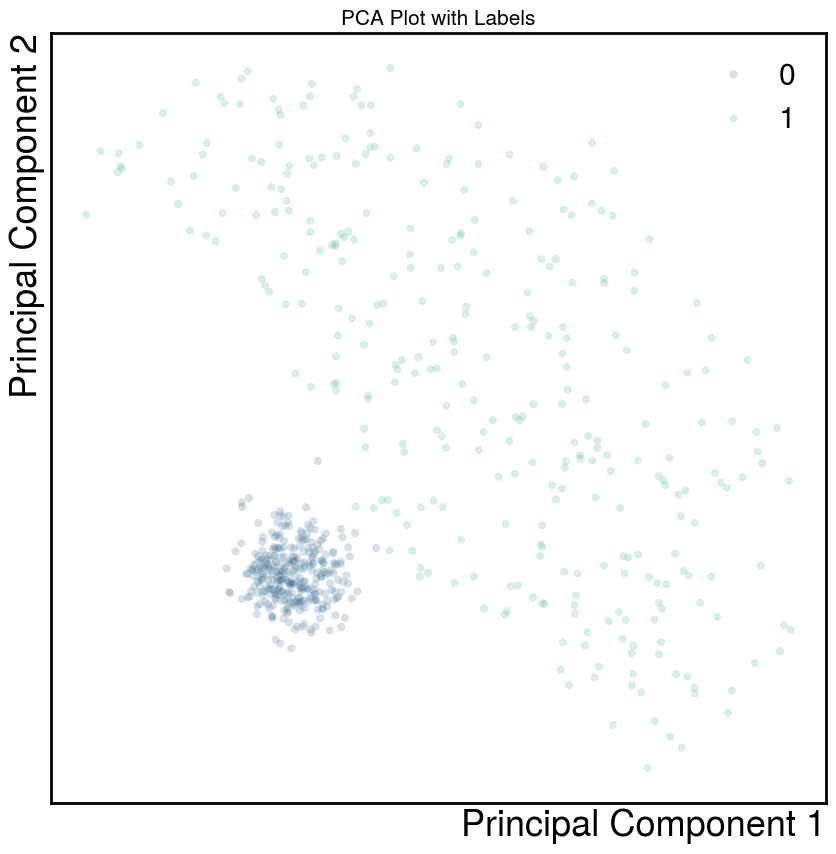

In [716]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(images_train.reshape(images_train.shape[0], -1))
sns.scatterplot(x=view[:,0], y=view[:,1], hue=labels_train, alpha=0.2, palette='viridis')
plt.title('PCA Plot with Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Remove ticks on both axes
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks

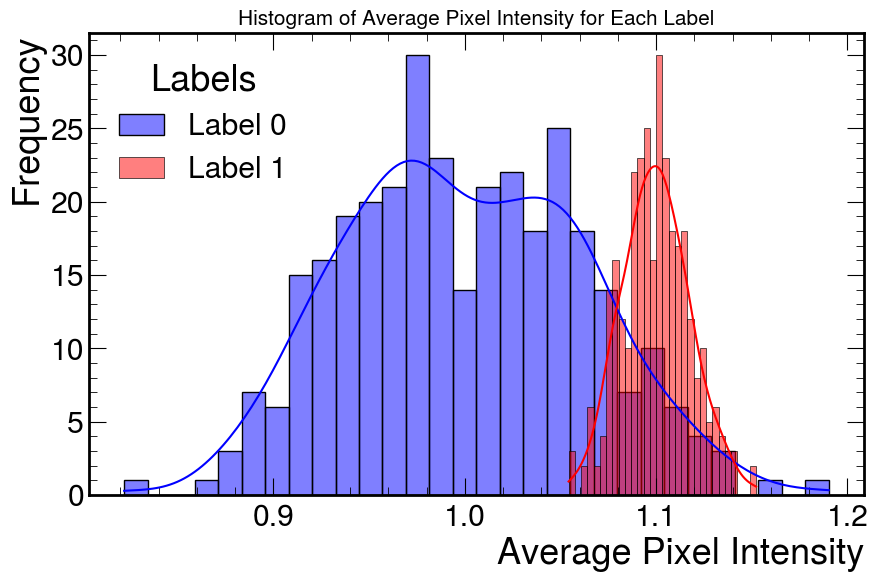

In [721]:
average_values = np.mean(images_train, axis=(1, 2))
plt.figure(figsize=(10, 6))
sns.histplot(average_values[labels_train == 0], color='blue', label='Label 0', kde=True, bins=30)
sns.histplot(average_values[labels_train == 1], color='red', label='Label 1', kde=True, bins=30)

# Customize plot
plt.title('Histogram of Average Pixel Intensity for Each Label')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(title='Labels')

# Show plot
plt.show()


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

# Function to compute region-wise average intensities (splitting image into 4 quadrants)
def compute_region_average(image):
    # Split the 16x16 image into 4 quadrants
    top_left = image[:8, :8]
    top_right = image[:8, 8:]
    bottom_left = image[8:, :8]
    bottom_right = image[8:, 8:]
    
    # Compute the average pixel intensity for each region
    return [np.mean(top_left), np.mean(top_right), np.mean(bottom_left), np.mean(bottom_right)]

region_averages = np.array([compute_region_average(img) for img in images_train])
vmax = region_averages.max()
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.heatmap(region_averages[labels_train == 1], cmap='YlOrRd', ax=ax[0], annot=False, vmin = 0, vmax = vmax)
ax[0].set_title('Region-wise Brightness (Positive Label)')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Image Index')

sns.heatmap(region_averages[labels_train == 0], cmap='YlOrRd', ax=ax[1], annot=False, vmin=0, vmax=vmax)
ax[1].set_title('Region-wise Brightness (Negative Label)')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Image Index')

cmap = cm.get_cmap('YlOrRd')  
norm = mpl.colors.Normalize(vmin=region_averages.min(), vmax=region_averages.max())

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'

### Separate Positive and Negative Labels

In [723]:
X_train = [img for img, label in zip(images_train, labels_train) if label == 0]
y_train = [label for label in labels_train if label == 0]
# keep the outliers in the training since they will join the training set for the student
outlier_train = [img for img, label in zip(images_train, labels_train) if label == 1]
outlier_train_labels = [label for label in labels_train if label == 1]

In [724]:
type(X_train), type(y_train), type(outlier_train), type(outlier_train_labels)

(list, list, list, list)

(-0.5, 15.5, 15.5, -0.5)

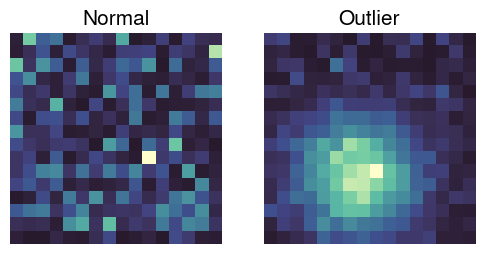

In [725]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(X_train[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Outlier")
plt.imshow(outlier_train[0])
plt.axis("off")

In [726]:
len(X_train), len(y_train), len(outlier_train), len(outlier_train_labels), len(images_train)

(326, 326, 314, 314, 640)

In [727]:
X_val = [img for img, label in zip(images_val, labels_val) if label == 0]
y_val = [label for label in labels_val if label == 0]
outlier_val = [img for img, label in zip(images_val, labels_val) if label == 1]
outlier_val_labels = [label for label in labels_val if label == 1]

In [728]:
len(X_val), len(y_val), len(outlier_val), len(outlier_val_labels), len(images_val)

(90, 90, 70, 70, 160)

In [729]:
X_test = [img for img, label in zip(images_test, labels_test) if label == 0]
y_test = [label for label in labels_test if label == 0]
outlier_test = [img for img, label in zip(images_test, labels_test) if label == 1]
outlier_test_labels = [label for label in labels_test if label == 1]

### (Tentative) Data Augmentation

In [327]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    tf.keras.layers.RandomRotation(0.3),  # Rotate up to 20%
    tf.keras.layers.RandomZoom(0.3),  # Zoom up to 20%
])

In [404]:
augmented_images = []
for image in X_train:
    for _ in range(10):
        augmented = data_augmentation(tf.expand_dims(image, axis=0))
        augmented_images.append(tf.squeeze(augmented).numpy())
X_train_aug = np.array(augmented_images)
y_train_aug = np.repeat(y_train, 100)

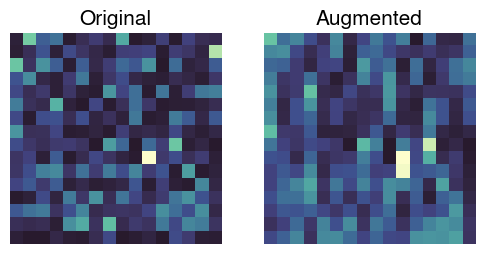

In [405]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented")
plt.imshow(X_train_aug[1])
plt.axis("off")


plt.show()

### Provided Model's Predictions

In [821]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record the start time
        result = func(*args, **kwargs)  # Call the original function
        end_time = time.time()  # Record the end time
        execution_time = end_time - start_time  # Calculate the execution time
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result  # Return the result of the function
    return wrapper

In [822]:
# TODO: again be coherent with the same format, especially if we consider quantization
# TODO: move in utils.py
@timer_decorator
def predict(images: NDArray[np.float64]) -> NDArray[np.float32]:
  output = infer(images)
  return output

def normalize_matrix(matrix: NDArray[np.float32]) -> NDArray[np.float32]:
  min_score = np.min(matrix)
  max_score = np.max(matrix)
  normalized_output = []
  for score in matrix:
    normalized_output.append((score - min_score)/(max_score-min_score))
  return np.array(normalized_output)

In [851]:
def plot_roc_curve(labs: NDArray[np.int32], preds: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labs, preds)
  print(len(thresholds))
  roc_auc = auc(fpr, tpr)
  # Plotting the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

  # Add labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()

In [824]:
#keras_model = tf.keras.models.load_model('model')
#keras_model = tf.keras.layers.TFSMLayer(model_path, call_endpoint = 'serving_default')ù
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']
input_tensor = tf.convert_to_tensor(images_test, dtype=tf.float32)

Execution time of predict: 0.0090 seconds


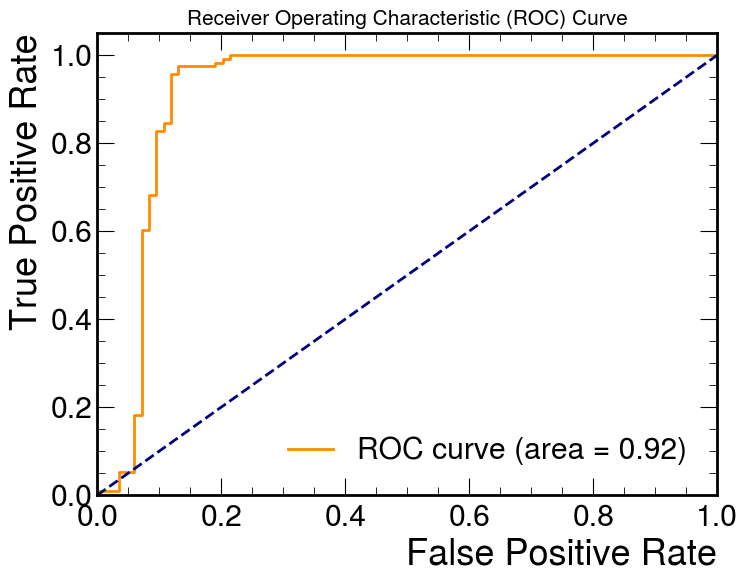

In [825]:
output = predict(input_tensor)
output = output['lambda'].numpy()
normalized_output = normalize_matrix(output)
plot_roc_curve(labels_test, normalized_output)
# idea: also add MSE 

### Proposed Model

In [434]:
from qkeras import QActivation, QConv2D, QDense, QDenseBatchnorm, quantized_bits
from tensorflow import keras, data
from keras.models import Model, load_model
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Reshape,
    UpSampling2D,
    Conv2DTranspose
)
import numpy.typing as npt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model

In [730]:
class TeacherAutoencoder:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
        p1 = layers.MaxPooling2D((2, 2))(x1)

        x2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
        p2 = layers.MaxPooling2D((2, 2))(x2)

        # Bottleneck
        x = Flatten(name="teacher_flatten")(p2)
        x = Dense(2, activation="relu", name="teacher_latent")(x)
        x = Dense(4 * 4 * 16, name="teacher_dense")(x)
        b = Reshape((4, 4, 16), name="teacher_reshape2")(x)
        # Decoder
        u1 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(b)
        u1 = layers.concatenate([u1, x2])
        u1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)

        u2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u1)
        u2 = layers.concatenate([u2, x1])
        u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(u2)
        return Model(inputs, outputs, name="teacher")

class TeacherAutoencoderRevised:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape
    # TODO: regularization techniques, learning-rate schedulers, batch_normalization
    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x = Reshape((16, 16, 1), name="teacher_reshape")(inputs)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
        x = Activation("relu", name="teacher_relu_1")(x)
        x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
        x = Activation("relu", name="teacher_relu_2")(x)
        x = Flatten(name="teacher_flatten")(x)
        x = Dense(80, activation="relu", name="teacher_latent")(x)
        x = Dense(8 * 8 * 30, name="teacher_dense")(x)
        x = Reshape((8, 8, 30), name="teacher_reshape2")(x)
        x = Activation("relu", name="teacher_relu_3")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
        x = Activation("relu", name="teacher_relu_4")(x)
        x = Conv2DTranspose(30, (3, 3), strides=2, padding="same", name="teacher_conv_transpose")(x)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
        x = Activation("relu", name="teacher_relu_5")(x)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(x)
        return Model(inputs, outputs, name="teacher-transpose")


class CicadaV2:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        # quantized_bits takes the following arguments:
        # total number of bits used to represent each weight value
        # number of bits used to represent the integer part
        # 1 bit if signed
        # scaling factor, 1.0 means no scaling
        x = QConv2D(
            4,
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            use_bias=False,
            name="dense2",
        )(x)
        #outputs = QActivation("quantized_relu(16, 8)", name="outputs")(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")


### Training

In [14]:
def autoencoder_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))  # Mean Squared Error

def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    # word contains the number of bits, int_ #bits for the integer part then 
    # calculates the number of bits for the decimal part and the step size
    # next the function calculates the maximum value that can be represented
    # finally it quantizes the array and clips the values to the maximum and 0
    word, int_ = precision 
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc

def train_model(
    model: Model,
    training_dataset: data.Dataset,
    validation_dataset: data.Dataset,
    epoch: int = 1,
    steps: int = 1,
    callbacks=None,
    verbose: bool = False,
) -> None:
    model.fit(
        training_dataset,
        steps_per_epoch=len(training_dataset), # the model process the entire dataset
        initial_epoch=epoch,
        epochs=epoch + steps,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=verbose,
    )
def get_student_targets(
    model: Model, gen: RegionETGenerator, X: npt.NDArray
) -> data.Dataset:
    X = np.expand_dims(X, axis=-1)
    X_hat = model.predict(X, batch_size=512, verbose=0)
    y = loss(X, X_hat) # FP32 loss
    y = quantize(y)
    #y = quantize(np.log(y) * 32)  # Scaled FP32 loss
    # arguments: input of the teacher model, quantized loss and batch size
    return gen.get_generator(X.reshape((-1, 256, 1)), y, 128, False)

NameError: name 'npt' is not defined

In [420]:
teacher = TeacherAutoencoder((16, 16, 1)).get_model()
teacher.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
#t_mc = ModelCheckpoint(f"models/{teacher.name}", save_best_only=True)
#t_log = CSVLogger(f"models/{teacher.name}/training.log", append=True)

In [421]:
teacher.summary()

Model: "teacher"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 teacher_inputs_ (InputLaye  [(None, 16, 16, 1)]          0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_167 (Conv2D)         (None, 16, 16, 8)            80        ['teacher_inputs_[0][0]']     
                                                                                                  
 max_pooling2d_68 (MaxPooli  (None, 8, 8, 8)              0         ['conv2d_167[0][0]']          
 ng2D)                                                                                            
                                                                                            

In [731]:
#cicada_v2 = CicadaV2((256,)).get_model()
cicada_v2 = CicadaV2((16, 16)).get_model()
cicada_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
#cv2_mc = ModelCheckpoint(f"models/{cicada_v2.name}", save_best_only=True)
#cv2_log = CSVLogger(f"models/{cicada_v2.name}/training.log", append=True)

In [ ]:
autoencoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Custom training step
@tf.function
def train_step(inputs, targets, train_student):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass through autoencoder
        reconstructed = teacher(inputs)
        # Compute the autoencoder (reconstruction) loss
        ae_loss = autoencoder_loss(inputs[:, :, :, None], reconstructed)
        adv_loss_sum = tf.constant(0.0, dtype=tf.float32)
        adv_loss = tf.constant(0.0, dtype=tf.float32)
        for batch in train_student:
            input_student, target_student = batch  # Assuming batch is (inputs, targets
            teacher_pred = teacher(input_student)
            loss_teacher = autoencoder_loss(tf.cast(input_student[:, :, :, None], tf.float32), teacher_pred)
            pred_student = cicada_v2(input_student)
            adv_loss = adversarial_loss(loss_teacher, pred_student)
            adv_loss_sum = tf.math.add(adv_loss_sum, tf.reduce_sum(adv_loss))
        
        total_loss = ae_loss
        #total_loss = ae_loss + 0.1 * adv_loss_sum 
        print(total_loss)
        
    # Compute gradients and apply them
    ae_gradients = tape.gradient(total_loss, teacher.trainable_variables)
    discriminator_gradients = tape.gradient(adv_loss, cicada_v2.trainable_variables)

    # Apply gradients
    autoencoder_optimizer.apply_gradients(zip(ae_gradients, teacher.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, cicada_v2.trainable_variables))

    return total_loss


In [863]:
gen = RegionETGenerator()

gen_train = gen.get_generator(np.array(X_train_aug), np.array(X_train_aug), 128, )
gen_val = gen.get_generator(images_val, images_val, 512, )

negative_test = gen.get_generator(X_test, X_test, 512, )
positive_test = gen.get_generator(outlier_test, outlier_test, 512, )

negative_test_student = gen.get_generator(np.array(X_test), np.array(y_test), 512, )
positive_test_student = gen.get_generator(np.array(outlier_test), np.array(outlier_test_labels), 512, )
#X_train_student = np.concatenate([X_train, outlier_train])
train_student = gen.get_generator(images_train, labels_train, 128, )
#X_val_student = np.concatenate([X_val, outlier_val])
X_val_student = outlier_val

In [583]:
only_cicada_dataset = gen.get_generator(images_train, quantize(labels_train), 128, )
only_cicada_val = gen.get_generator(images_val, quantize(labels_val), 128, )

In [ ]:
# Train loop
for epoch in range(2):
    for batch in gen_train:
        inputs, targets = batch  # Assuming batch is (inputs, targets)
        loss = train_step(inputs, targets, train_student)
    print(f"Epoch {epoch}, Loss: {loss.numpy()}")

In [586]:
for epoch in range(5):
    train_model(
        cicada_v2,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 3ms/step - loss: 0.1520 - val_loss: 0.0974
Epoch 2/2
5/5 [==============================] - 0s 2ms/step - loss: 0.1142 - val_loss: 0.0617
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0411
Epoch 4/4
5/5 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0316
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0238


In [ ]:
for epoch in range(10):
    """
    train_model(
        teacher,
        gen_train,
        gen_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )
    #tmp_teacher = load_model(f"models/{teacher.name}")
    tmp_teacher = teacher"
    """
    #s_gen_train = get_student_targets(tmp_teacher, gen, X_train_student)
    #s_gen_val = get_student_targets(tmp_teacher, gen, X_val_student)

    s_gen_train = get_student_targets(teacher, gen, X_train_student)
    s_gen_val = get_student_targets(teacher, gen, X_val_student)
    train_model(
            cicada_v2,
            s_gen_train,
            s_gen_val,
            epoch=10 * epoch,
            steps=10,
            #callbacks=[cv2_mc, cv2_log],
            verbose=1,
        )

In [427]:
teacher.evaluate(negative_test, verbose=1), teacher.evaluate(positive_test)

1/1 [==============================] - 0s 9ms/step - loss: 0.0054


(0.0328376367688179, 0.005389452911913395)

In [ ]:
cicada_v2.evaluate(positive_test, verbose=1)

In [550]:
import importlib
import drawing
import generator
importlib.reload(drawing)
importlib.reload(generator)
from drawing import Draw
draw = Draw(output_dir='plots', interactive=False)

In [551]:
def plot_reconstruction(index: int, dataset, model):
    # Extract a single example from the augmented training set
    image_example = dataset[index][np.newaxis, ...]

    # Get the model's prediction
    y_pred = model.predict(image_example)

    # Calculate the error
    error = loss(dataset[index][..., np.newaxis], y_pred)
    print(error)

    # Plot the reconstruction results
    draw.plot_reconstruction_results(
        dataset[index],
        y_pred,
        loss=error[0],
        name="comparison-background",
    )


In [432]:
# it acts as if it's been trained also on the outliers. I can find only 2 reasons:
# 1. the teacher model is too good at generalizing
# 2. dataset also contained outliers
plot_reconstruction(25, outlier_test, teacher)

1/1 [==============================] - 0s 11ms/step
[0.00325335]


In [232]:
index = 50
# Extract a single example from the augmented training set
image_example = X_val[index].astype(np.float32)[np.newaxis, ...]

# Get the model's prediction
y_pred = teacher.predict(image_example)

# Calculate the error
error = loss(X_val[index][..., np.newaxis], y_pred)

# Plot the reconstruction results
draw.plot_reconstruction_results(
    X_val[index],
    y_pred,
    loss=error[0],
    name="comparison-background",
)

1/1 [==============================] - 0s 10ms/step


In [578]:
y_pred_teacher = teacher.predict(np.array(images_test)[:, :, :, None], verbose=1)

7/7 [==============================] - 0s 3ms/step


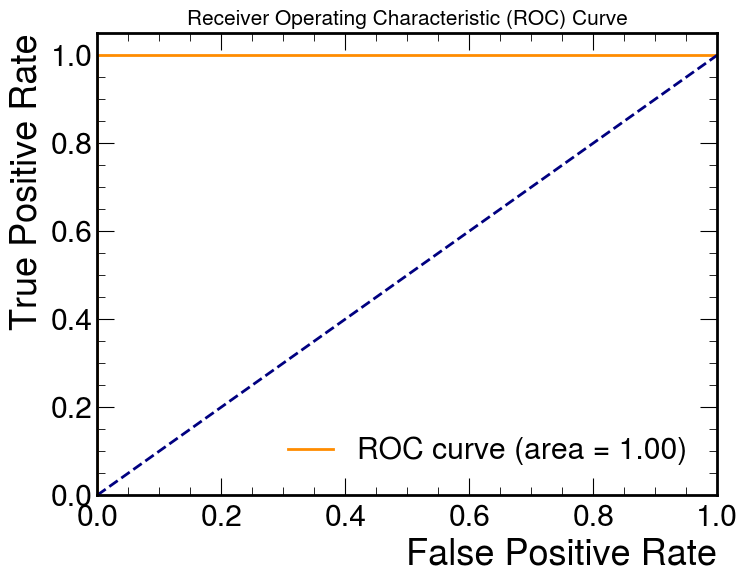

In [345]:
plot_roc_curve(labels_test, y_pred_teacher)

In [68]:
y_pred_teacher = teacher.predict(np.array(images_test)[:, :, :, None], verbose=1)
y_loss_teacher = loss(images_test[:, :, :, None], y_pred_teacher)
y_loss_cicada = cicada_v2.predict(np.array(images_test).reshape((-1, 256)), verbose=1)

7/7 [==============================] - 0s 507us/step


In [587]:
y_loss_cicada = cicada_v2.predict(np.array(images_test), verbose=1)

7/7 [==============================] - 0s 542us/step


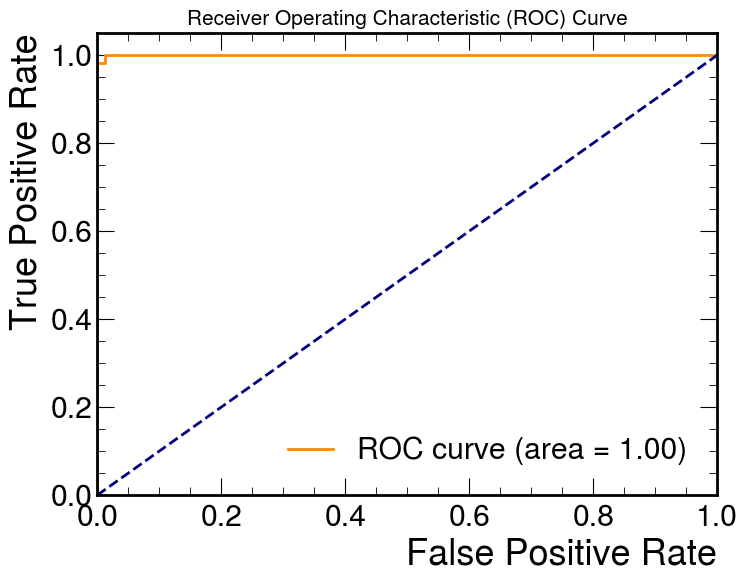

In [589]:
normalized_output = normalize_matrix(y_loss_cicada)
plot_roc_curve(labels_test, normalized_output)

### Further Improvements

Since CICADAV2 with minimal training reaches perfect classification, we can go further through a decrease in the number of connections

In [732]:
cicada_v2.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 8, 8, 4)           16        
                                                                 
 relu0 (QActivation)         (None, 8, 8, 4)           0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                41

In [733]:
class CicadaV3:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        x = QConv2D(
            2, # decrease the number of filters
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(8, 3, 1, alpha=1.0), # decrease the number of bits (fractional part)
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(8, 3, 1, alpha=1.0), # decrease the number of bits (fractional part)
            use_bias=False,
            name="dense2",
        )(x)
        #outputs = QActivation("quantized_relu(16, 8)", name="outputs")(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")

In [763]:
cicada_v3 = CicadaV3((16, 16)).get_model()
cicada_v3.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [755]:
only_cicada_dataset = gen.get_generator(images_train, quantize(labels_train), 128, )
only_cicada_val = gen.get_generator(images_val, quantize(labels_val), 128, )

In [764]:
for epoch in range(10):
    train_model(
        cicada_v3,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 22ms/step - loss: 0.3079 - val_loss: 0.2675
Epoch 2/2
5/5 [==============================] - 0s 2ms/step - loss: 0.2718 - val_loss: 0.2447
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.2374 - val_loss: 0.2272
Epoch 4/4
5/5 [==============================] - 0s 2ms/step - loss: 0.2064 - val_loss: 0.2122
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.1849 - val_loss: 0.1998
Epoch 6/6
5/5 [==============================] - 0s 2ms/step - loss: 0.1525 - val_loss: 0.1897
Epoch 7/7
5/5 [==============================] - 0s 2ms/step - loss: 0.1429 - val_loss: 0.1799
Epoch 8/8
5/5 [==============================] - 0s 2ms/step - loss: 0.1264 - val_loss: 0.1710
Epoch 9/9
5/5 [==============================] - 0s 2ms/step - loss: 0.1083 - val_loss: 0.1624
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1006 - val_loss: 0.1574


7/7 [==============================] - 0s 500us/step


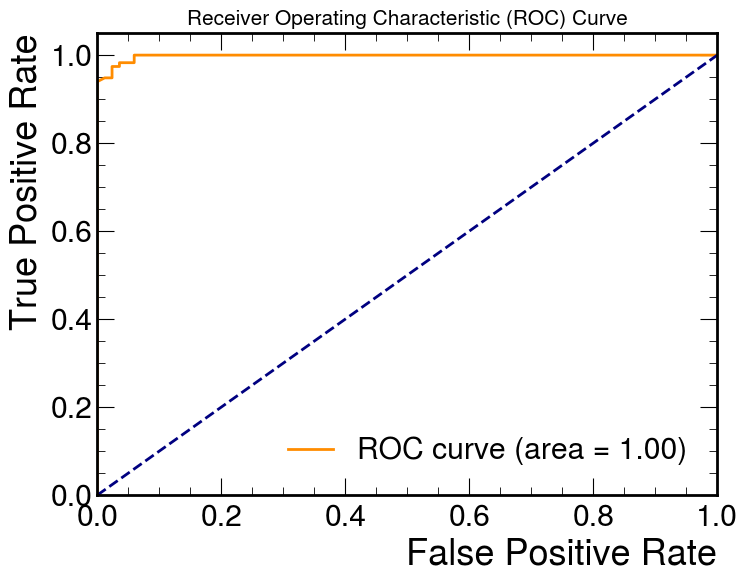

In [765]:
y_loss_cicada = cicada_v3.predict(np.array(images_test), verbose=1)
plot_roc_curve(labels_test, y_loss_cicada)

In [766]:
cicada_v3.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 8, 8, 2)           8         
                                                                 
 relu0 (QActivation)         (None, 8, 8, 2)           0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout_46 (Dropout)        (None, 128)               0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 16)                21

clearly still room for improvement!

In [816]:
class CicadaV4:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        x = QConv2D(
            1, # decrease the number of filters
            (4, 4),
            strides=4,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(4, 2, 1, alpha=1.0), # decrease the number of bits (fractional part)
            name="conv",
        )(x)
        x = QActivation("quantized_relu(4, 2)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            2,
            kernel_quantizer=quantized_bits(4, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(4, 2, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(4, 2)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(4, 2, 1, alpha=1.0), # decrease the number of bits (fractional part)
            use_bias=False,
            name="dense2",
        )(x)
        outputs = Activation("sigmoid", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")

In [830]:
cicada_v4 = CicadaV4((16, 16)).get_model()
cicada_v4.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

In [831]:
for epoch in range(100):
    train_model(
        cicada_v4,
        only_cicada_dataset,
        only_cicada_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )

5/5 [==============================] - 0s 22ms/step - loss: 0.2861 - val_loss: 0.2446
Epoch 2/2
5/5 [==============================] - 0s 1ms/step - loss: 0.2903 - val_loss: 0.2481
Epoch 3/3
5/5 [==============================] - 0s 2ms/step - loss: 0.2918 - val_loss: 0.2481
Epoch 4/4
5/5 [==============================] - 0s 1ms/step - loss: 0.3024 - val_loss: 0.2481
Epoch 5/5
5/5 [==============================] - 0s 2ms/step - loss: 0.3001 - val_loss: 0.2481
Epoch 6/6
5/5 [==============================] - 0s 2ms/step - loss: 0.2900 - val_loss: 0.2444
Epoch 7/7
5/5 [==============================] - 0s 1ms/step - loss: 0.2865 - val_loss: 0.2444
Epoch 8/8
5/5 [==============================] - 0s 2ms/step - loss: 0.2795 - val_loss: 0.2444
Epoch 9/9
5/5 [==============================] - 0s 2ms/step - loss: 0.2809 - val_loss: 0.2444
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.2899 - val_loss: 0.2515
Epoch 11/11
5/5 [==============================] - 0s 1ms

7/7 [==============================] - 0s 532us/step
21


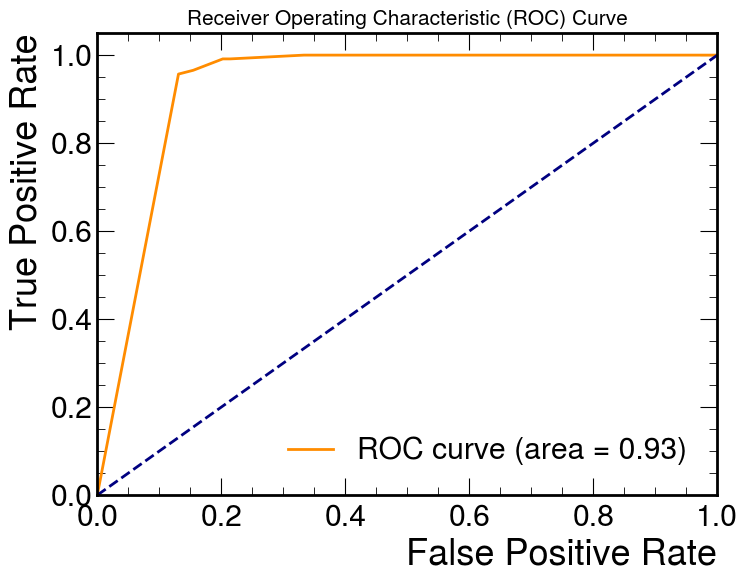

In [852]:
y_loss_cicada = cicada_v4.predict(np.array(images_test), verbose=1)
plot_roc_curve(labels_test, y_loss_cicada)

In [833]:
cicada_v4.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 16, 16)]          0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv (QConv2D)              (None, 4, 4, 1)           16        
                                                                 
 relu0 (QActivation)         (None, 4, 4, 1)           0         
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dropout_74 (Dropout)        (None, 16)                0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 2)                 43

We can (almost) count the parameters on the fingers of an hand. Let's see how fast the model is, shall we?

In [858]:
@timer_decorator
def predict_image(model: Model, image: npt.NDArray) -> npt.NDArray:
    return model.predict(image)

In [860]:
predict_image(cicada_v4, quantize(images_test[18][None, :, :]))

1/1 [==============================] - 0s 8ms/step
Execution time of predict_image: 0.0287 seconds


array([[0.5]], dtype=float32)

In [864]:
cicada_v4.evaluate(positive_test_student, verbose=1)

1/1 [==============================] - 0s 114ms/step - loss: 0.2532


0.2531704008579254

In [865]:
cicada_v4.evaluate(negative_test_student, verbose=1)

1/1 [==============================] - 0s 17ms/step - loss: 0.0929


0.09291359037160873

### HGQ

In [44]:
from HGQ.layers import HDense, HConv2D, PMaxPooling2D, PFlatten, PReshape, HQuantize, HActivation
from HGQ import ResetMinMax, FreeBOPs
from HGQ import trace_minmax, to_proxy_model

In [45]:
model = keras.models.Sequential([
    HQuantize(beta=3e-5),
    PReshape((16, 16, 1)),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=144),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=16),
    #PMaxPooling2D((2, 2)),
    PFlatten(),
    HDense(1, activation='linear', beta=3e-5),
    HActivation('sigmoid')
])


In [8]:
from tensorflow import keras, data

In [46]:
opt = keras.optimizers.Adam(learning_rate=0.001)
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = 'binary_crossentropy'
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
callbacks = [ResetMinMax(), FreeBOPs()]

In [48]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
23/23 [==============================] - 0s 3ms/step - loss: 1.3624 - accuracy: 0.5000 - val_loss: 1.3940 - val_accuracy: 0.5250 - bops: 23340.0000
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 1.3530 - accuracy: 0.5000 - val_loss: 1.3658 - val_accuracy: 0.5250 - bops: 22400.0000
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 1.3115 - accuracy: 0.5000 - val_loss: 1.3088 - val_accuracy: 0.5250 - bops: 20502.0000
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 1.2628 - accuracy: 0.5000 - val_loss: 1.3076 - val_accuracy: 0.5250 - bops: 20461.0000
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 1.2505 - accuracy: 0.5000 - val_loss: 1.2322 - val_accuracy: 0.5250 - bops: 17948.0000
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 1.2018 - accuracy: 0.6056 - val_loss: 1.1734 - val_accuracy: 0.7625 - bops: 19196.0000
Epoch 7/50
23/23 [============================

2025-03-21 22:45:36.563572: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


23/23 [==============================] - 0s 2ms/step - loss: 1.0883 - accuracy: 0.8847 - val_loss: 1.1252 - val_accuracy: 0.8875 - bops: 20481.0000
Epoch 14/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0894 - accuracy: 0.8847 - val_loss: 1.1104 - val_accuracy: 0.8875 - bops: 20585.0000
Epoch 15/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0792 - accuracy: 0.8917 - val_loss: 1.0967 - val_accuracy: 0.8875 - bops: 20489.0000
Epoch 16/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0706 - accuracy: 0.8917 - val_loss: 1.0589 - val_accuracy: 0.9000 - bops: 19637.0000
Epoch 17/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0445 - accuracy: 0.8819 - val_loss: 1.0586 - val_accuracy: 0.9000 - bops: 19626.0000
Epoch 18/50
23/23 [==============================] - 0s 2ms/step - loss: 1.0363 - accuracy: 0.8861 - val_loss: 1.0676 - val_accuracy: 0.8750 - bops: 19590.0000
Epoch 19/50
23/23 [==============================] -

In [49]:
trace_minmax(model, X_train, cover_factor=1.0)

h_quantize_4: 0.0
h_conv2d_8: 7320.0
h_conv2d_9: 1296.0
h_dense_3: 24.0
h_activation: 0.0


8640.0

In [38]:
test_size = 0.2
validation_size = 0.1
total_samples = len(images)

# Generate a list of indices and shuffle them
indices = np.random.permutation(total_samples)

# Calculate the split indices
test_split_index = int(total_samples * (1 - test_size))
validation_split_index = int(test_split_index * (1 - validation_size))

# Split the data into training, validation, and test sets
X_train, X_val, X_test = images[indices[:validation_split_index]], images[indices[validation_split_index:test_split_index]], images[indices[test_split_index:]]
y_train, y_val, y_test = labels[indices[:validation_split_index]], labels[indices[validation_split_index:test_split_index]], labels[indices[test_split_index:]]

In [50]:
proxy = to_proxy_model(model, aggressive=True)

In [51]:
from hls4ml.converters import convert_from_keras_model

ModuleNotFoundError: No module named 'hls4ml'